In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
from pathlib import Path
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Load data
image_dir = Path(r"C:\Users\net pc\Desktop\Liver_tumor_data")

if image_dir.exists():
    print("Path exists.")
else:
    print("Path does not exist.")

filepaths = list(image_dir.glob(r'*/*.jpeg')) 

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

print("Number of files found:", len(filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

print("Number of rows in image_df:", len(image_df))



Path exists.
Number of files found: 1910
Number of rows in image_df: 1910


In [3]:
image_df

,Filepath,Label
0,C:\Users\net pc\Desktop\Liver_tumor_data\benig...,benign_jpg
1,C:\Users\net pc\Desktop\Liver_tumor_data\benig...,benign_jpg
2,C:\Users\net pc\Desktop\Liver_tumor_data\benig...,benign_jpg
3,C:\Users\net pc\Desktop\Liver_tumor_data\benig...,benign_jpg
4,C:\Users\net pc\Desktop\Liver_tumor_data\benig...,benign_jpg
...,...,...
1905,C:\Users\net pc\Desktop\Liver_tumor_data\norma...,normal_jpg
1906,C:\Users\net pc\Desktop\Liver_tumor_data\norma...,normal_jpg
1907,C:\Users\net pc\Desktop\Liver_tumor_data\norma...,normal_jpg
1908,C:\Users\net pc\Desktop\Liver_tumor_data\norma...,normal_jpg


In [4]:
train_df, test_df = train_test_split(image_df, train_size=0.80, shuffle=True, random_state=1)

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:


train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  horizontal_flip=True,
                                                                  width_shift_range=0.2,
                                                                  height_shift_range=0.2,
                                                                  validation_split=0.2)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [7]:
train_images = train_generator.flow_from_dataframe(dataframe=train_df,
                                                   x_col='Filepath',
                                                   y_col='Label',
                                                   target_size=(64, 64),
                                                   color_mode='rgb',
                                                   class_mode='categorical',
                                                   batch_size=32,
                                                   shuffle=True,
                                                   seed=42,
                                                   subset='training')

val_images = train_generator.flow_from_dataframe(dataframe=train_df,
                                                 x_col='Filepath',
                                                 y_col='Label',
                                                 target_size=(64, 64),
                                                 color_mode='rgb',
                                                 class_mode='categorical',
                                                 batch_size=32,
                                                 shuffle=True,
                                                 seed=42,
                                                 subset='validation')

test_images = test_generator.flow_from_dataframe(dataframe=test_df,
                                                 x_col='Filepath',
                                                 y_col='Label',
                                                 target_size=(64, 64),
                                                 color_mode='rgb',
                                                 class_mode='categorical',
                                                 batch_size=32,
                                                 shuffle=False)

Found 1223 validated image filenames belonging to 3 classes.
Found 305 validated image filenames belonging to 3 classes.
Found 382 validated image filenames belonging to 3 classes.


In [8]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv3D, MaxPool3D , Dropout, Flatten
from tensorflow.keras.layers import Dropout

ResNet = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(64, 64, 3))


#ResNet = ResNet50(input_shape= (64, 64, 3), weights='imagenet', include_top=False)
ResNet.trainable = False

In [9]:
model = keras.Sequential([
    ResNet,
    keras.layers.Flatten(),
#    keras.layers.Dropout(0.5),
#    keras.layers.Dense(units=32, activation='relu'),
#    keras.layers.Dropout(0.25),
    keras.layers.Dense(units=3, activation='softmax'),
])

In [10]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ ?                           │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [12]:
for layer in model.layers:
    print(layer, layer.trainable)

<Functional name=resnet50, built=True> False
<Flatten name=flatten, built=False> True
<Dense name=dense, built=False> True


In [13]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=3
        )
    ]
)

Epoch 1/50


C:\Users\Public\Efendim\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 18s 262ms/step - accuracy: 0.4530 - loss: 1.0707 - val_accuracy: 0.4721 - val_loss: 1.0452 - learning_rate: 0.0010
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.4984 - loss: 1.0170 - val_accuracy: 0.5213 - val_loss: 0.9774 - learning_rate: 0.0010
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.5088 - loss: 0.9696 - val_accuracy: 0.4820 - val_loss: 0.9842 - learning_rate: 0.0010
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.5054 - loss: 0.9650 - val_accuracy: 0.5377 - val_loss: 0.9730 - learning_rate: 0.0010
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.4895 - loss: 0.9742 - val_accuracy: 0.5443 - val_loss: 0.9969 - learning_rate: 0.0010
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.4945 - loss: 0.9714 - val_accuracy: 0.4820 - val_loss: 0.9700 - learning_rate: 0.0010
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.5001 - loss: 0.9850 - val_accura

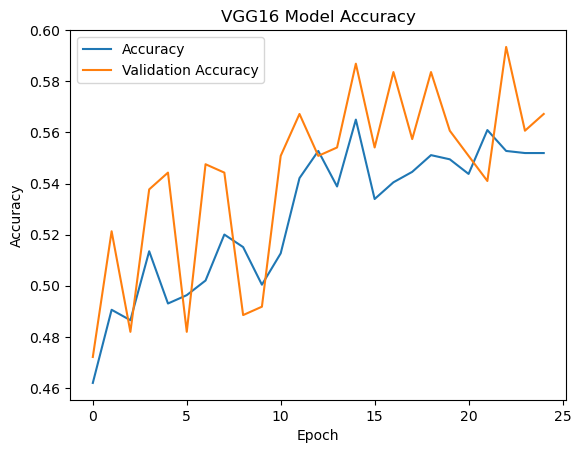

In [14]:
import matplotlib.pyplot as plt

#plt.figure(figsize=(14, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNet50 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Validation Accuracy', 'loss', 'Validation Loss'])
plt.show()

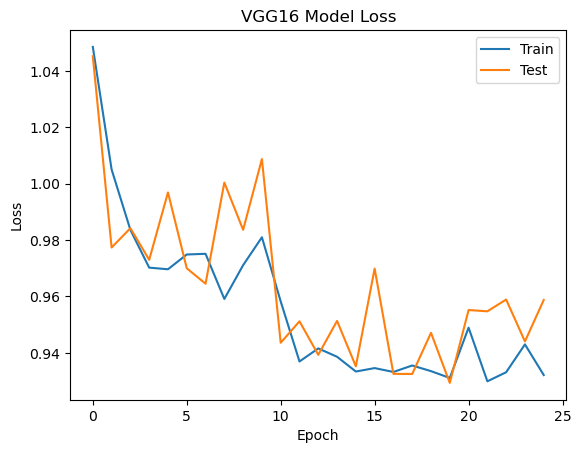

In [15]:
import matplotlib.pyplot as plt

#plt.figure(figsize=(14, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('VGG16 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [16]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.94382
Test Accuracy: 51.83%


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step


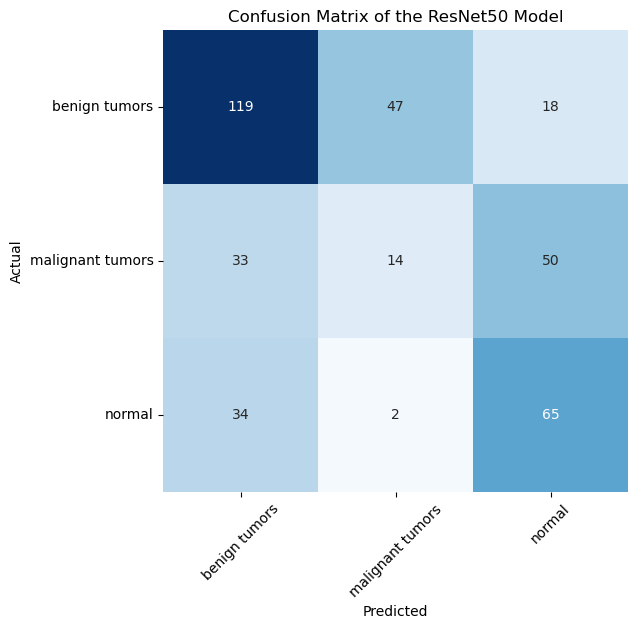

Classification Report:
----------------------
                   precision    recall  f1-score   support

   benign tumors       0.64      0.65      0.64       184
malignant tumors       0.22      0.14      0.17        97
          normal       0.49      0.64      0.56       101

        accuracy                           0.52       382
       macro avg       0.45      0.48      0.46       382
    weighted avg       0.49      0.52      0.50       382



In [17]:

# Convert labels to one-hot encoding
from keras.utils import to_categorical

test_labels_onehot = to_categorical(test_images.labels, num_classes=3)

# Predict classes
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Create confusion matrix
cm = confusion_matrix(np.argmax(test_labels_onehot, axis=1), predicted_classes)

# Create classification report
clr = classification_report(np.argmax(test_labels_onehot, axis=1), predicted_classes, target_names=["benign tumors", "malignant tumors", "normal"])

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(3) + 0.5, labels=["benign tumors", "malignant tumors", "normal"], rotation=45)
plt.yticks(ticks=np.arange(3) + 0.5, labels=["benign tumors", "malignant tumors", "normal"], rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix of the ResNet50 Model")
plt.show()

# Print classification report
print("Classification Report:\n----------------------\n", clr)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step


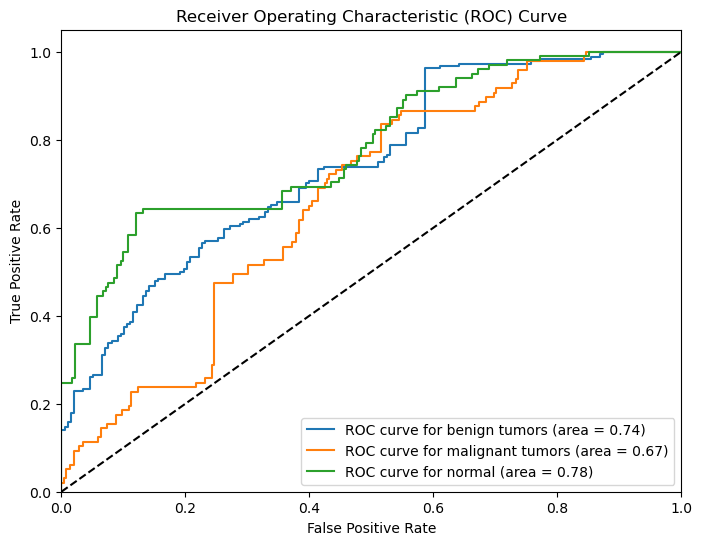

AUC ROC for benign tumors: 0.74201
AUC ROC for malignant tumors: 0.66594
AUC ROC for normal: 0.78324


In [18]:
# Obtain predicted probabilities
predicted_probabilities = model.predict(test_images)

# Import necessary libraries
from sklearn.metrics import roc_auc_score, roc_curve

# Convert labels to one-hot encoding
from keras.utils import to_categorical
test_labels_onehot = to_categorical(test_images.labels, num_classes=3)

# Compute AUC ROC for each class
auc_roc = dict()
for i in range(3):
    auc_roc[i] = roc_auc_score(test_labels_onehot[:, i], predicted_probabilities[:, i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(3):
    fpr, tpr, _ = roc_curve(test_labels_onehot[:, i], predicted_probabilities[:, i])
    plt.plot(fpr, tpr, label='ROC curve for {} (area = {:.2f})'.format(["benign tumors", "malignant tumors", "normal"][i], auc_roc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print AUC ROC for each class
for i in range(3):
    print("AUC ROC for {}: {:.5f}".format(["benign tumors", "malignant tumors", "normal"][i], auc_roc[i]))


In [19]:
# save the model to a file
#model.save('ResNet50-Brain Tumor vs Kidney tumor .h5')